In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = '04272021'
ds_folder = f'../data/{ds_name}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/04272021\cluster_dynamics.csv
../data/04272021\duplicate_trees.csv
../data/04272021\edges.csv
../data/04272021\err_nodes.csv


In [2]:
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [3]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/cluster_dynamics.csv')
edge_df = pd.read_csv(f'{ds_folder}/edges.csv')

In [4]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (3990589, 20)
Shape of edge data is (3948750, 5)


In [5]:
edge_df.tail()

,from,to,weight1,weight2,sim
3948745,1180,136,3,0.002905,99
3948746,1180,317,7,0.006492,99
3948747,1179,1181,8,0.006875,99
3948748,1181,98,15,0.014371,99
3948749,1181,605,20,0.017163,99


In [6]:
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3948750 entries, 0 to 3948749
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   from     int64  
 1   to       int64  
 2   weight1  int64  
 3   weight2  float64
 4   sim      int64  
dtypes: float64(1), int64(4)
memory usage: 150.6 MB


In [7]:
#drop non-node data points
drop_node = np.where(pd.isna(node_df['node'])==True)
node_df = node_df.drop(drop_node[0])
print('Number of dropped node is', len(drop_node[0]))

node_df['sim'] = pd.to_numeric(node_df['sim'])
node_df['dynamic_model'] = pd.to_numeric(node_df['dynamic_model'])

Number of dropped node is 39032


### Count number of trees

In [8]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 2315


### Error check duplicate number of nodes and edges on a tree
Number of nodes for one tree should equal to number of edges plus 1. 

In [9]:
err_dic = {}
err_treeids = []
for one_tree_id in node_tree_ids:
    onetree_node_df = node_df[node_df['sim'] == one_tree_id] 
    uni_node_sample = onetree_node_df.drop_duplicates()
    uni_node = onetree_node_df.drop_duplicates('node')
    onetree_edge_df = edge_df[edge_df['sim'] == one_tree_id]
    uni_edge_sample = onetree_edge_df.drop_duplicates()
    uni_edge = onetree_edge_df.drop_duplicates(['from','to'])
    if len(uni_node) == len(uni_edge)+1:
        continue
    else:
        err_dic[one_tree_id] = [len(onetree_node_df),len(uni_node_sample),len(uni_node),len(onetree_edge_df),len(uni_edge_sample),len(uni_edge)]
        err_treeids.append(one_tree_id)
        node_df = node_df.drop(node_df[node_df['sim']==one_tree_id].index)
        edge_df = edge_df.drop(edge_df[edge_df['sim']==one_tree_id].index)
#         if len(err_treeids) == 1:
#             err_node_df = onetree_node_df
#             err_edge_df = onetree_edge_df
#         else:
#             err_node_df = err_node_df.append(onetree_node_df)
#             err_edge_df = err_edge_df.append(onetree_edge_df)



In [10]:
print('The id of error tree:')
print(err_treeids)

The id of error tree:
[1004, 1041, 1064, 1065, 1069, 1090, 1096, 1109, 110, 1119, 1120, 1127, 114, 1151, 1152, 1155, 1160, 1162, 1175, 1176, 1177, 1198, 11, 1207, 1212, 122, 1234, 1247, 1260, 1279, 127, 1282, 1284, 1304, 1315, 1327, 1330, 1335, 1339, 1341, 1347, 1351, 1355, 1356, 135, 1368, 1373, 1374, 1387, 1408, 1410, 1415, 1427, 1434, 1443, 1464, 1480, 1486, 1498, 1500, 1502, 1519, 1525, 1528, 152, 1535, 1555, 1556, 1559, 1560, 1567, 1568, 1570, 1571, 1577, 1587, 1601, 1603, 160, 1610, 1612, 161, 1620, 1624, 1636, 1639, 1651, 1691, 1707, 1713, 1715, 1721, 1730, 1735, 1736, 173, 1742, 1744, 1751, 1771, 1779, 1781, 1786, 1791, 1798, 1806, 1808, 1812, 1818, 1837, 1843, 1848, 1852, 1855, 1860, 1874, 187, 1899, 1902, 1903, 1905, 1915, 1929, 1932, 1934, 1940, 1946, 1953, 1971, 1979, 1980, 1984, 1994, 1995, 2003, 2009, 2010, 2012, 2019, 204, 2057, 2058, 2059, 205, 2096, 2099, 210, 2113, 2126, 2147, 2148, 2168, 2170, 2177, 2189, 2192, 2208, 2218, 2235, 2240, 2242, 2252, 2253, 2256, 226, 227

In [11]:
err_df = pd.DataFrame.from_dict(err_dic, orient='index', 
                                columns=["#raw_nodes", 
                                         "#unique_nodes_consider_feats", "#unique_nodes_no_consider_feats", 
                                         "#raw_edges", "#unique_edges_consider_feats", "#unique_edges_no_consider_feats"])
err_df.index.name = "sim"
err_df

,#raw_nodes,#unique_nodes_consider_feats,#unique_nodes_no_consider_feats,#raw_edges,#unique_edges_consider_feats,#unique_edges_no_consider_feats
sim,,,,,,
1004,2702,2702,1418,2700,2700,2448
1041,2938,2938,1504,2936,2936,2639
1064,2682,2682,1470,2680,2680,2466
1065,3277,3277,1655,3275,3275,2959
1069,2891,2891,1494,2889,2889,2602
...,...,...,...,...,...,...
959,3030,3030,1578,3028,3028,2752
981,2999,2999,1594,2997,2997,2733
985,2749,2749,1414,2747,2747,2485


In [12]:
err_df.to_csv(f"{ds_folder}/duplicate_trees.csv")

In [13]:
print('Number of error tree is',len(err_treeids))
print('For error tree',err_treeids[0])
print(f'Number of node samples: {err_dic[err_treeids[0]][0]}')
print(f'Number of unique node samples: {err_dic[err_treeids[0]][1]}')
print(f'Number of unique nodes: {err_dic[err_treeids[0]][2]}')
print(f'Number of edge samples: {err_dic[err_treeids[0]][3]}')
print(f'Number of unique edge samples: {err_dic[err_treeids[0]][4]}')
print(f'Number of unique edges: {err_dic[err_treeids[0]][5]}')

Number of error tree is 492
For error tree 1004
Number of node samples: 2702
Number of unique node samples: 2702
Number of unique nodes: 1418
Number of edge samples: 2700
Number of unique edge samples: 2700
Number of unique edges: 2448


err_node_df.to_csv(f"{ds_folder}/err_tree_nodes.csv")
err_node_df

err_edge_df.to_csv(f"{ds_folder}/err_tree_edges.csv")
err_edge_df

### Analysis the edge weights

In [14]:
aly_edge_feat_cols = ['weight1', 'weight2']
aly_edge_df = edge_df[aly_edge_feat_cols]

In [15]:
aly_edge_df.describe()

,weight1,weight2
count,2.552371e+06,2.552371e+06
mean,1.164043e+01,1.047744e-02
std,9.492066e+00,8.588479e-03
min,0.000000e+00,0.000000e+00
25%,4.000000e+00,3.761862e-03
50%,9.000000e+00,8.227141e-03
75%,1.700000e+01,1.520915e-02
max,1.000000e+02,8.970291e-02


array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

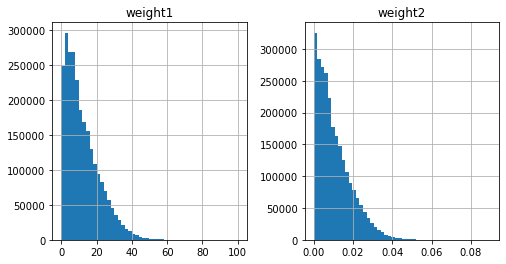

In [16]:
aly_edge_df.hist(bins=50,figsize=(8,4))

In [17]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_edge_df.corr()

,weight1,weight2
weight1,1.000000,0.994881
weight2,0.994881,1.000000


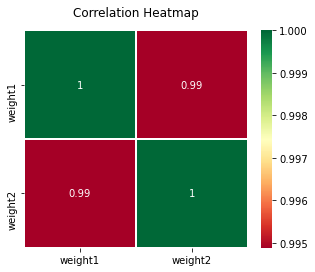

In [18]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(5, 4))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_edge_df.corr(), annot=True, linewidths=.5, cmap="RdYlGn")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', pad=14);

### Get the node and edge distribution of the trees

In [19]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 1823


In [20]:
from collections import defaultdict

tree_dist_dict = defaultdict(list)

for tree_id in tree_ids:
    tree_dist_dict['sim'].append(tree_id)
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    tree_dist_dict['num_nodes'].append(num_nodes)
    
    #num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    #tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    #tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        tree_dist_dict[f'num_{label}_nodes'].append(num_label_nodes)
        tree_dist_dict[f'rat_{label}_nodes'].append(num_label_nodes / num_nodes)
        
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    tree_dist_dict['num_edges'].append(onetree_edge_df.shape[0])
    
tree_dist_df = pd.DataFrame.from_dict(tree_dist_dict)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'rat_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'rat_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'rat_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>]], dtype=object)

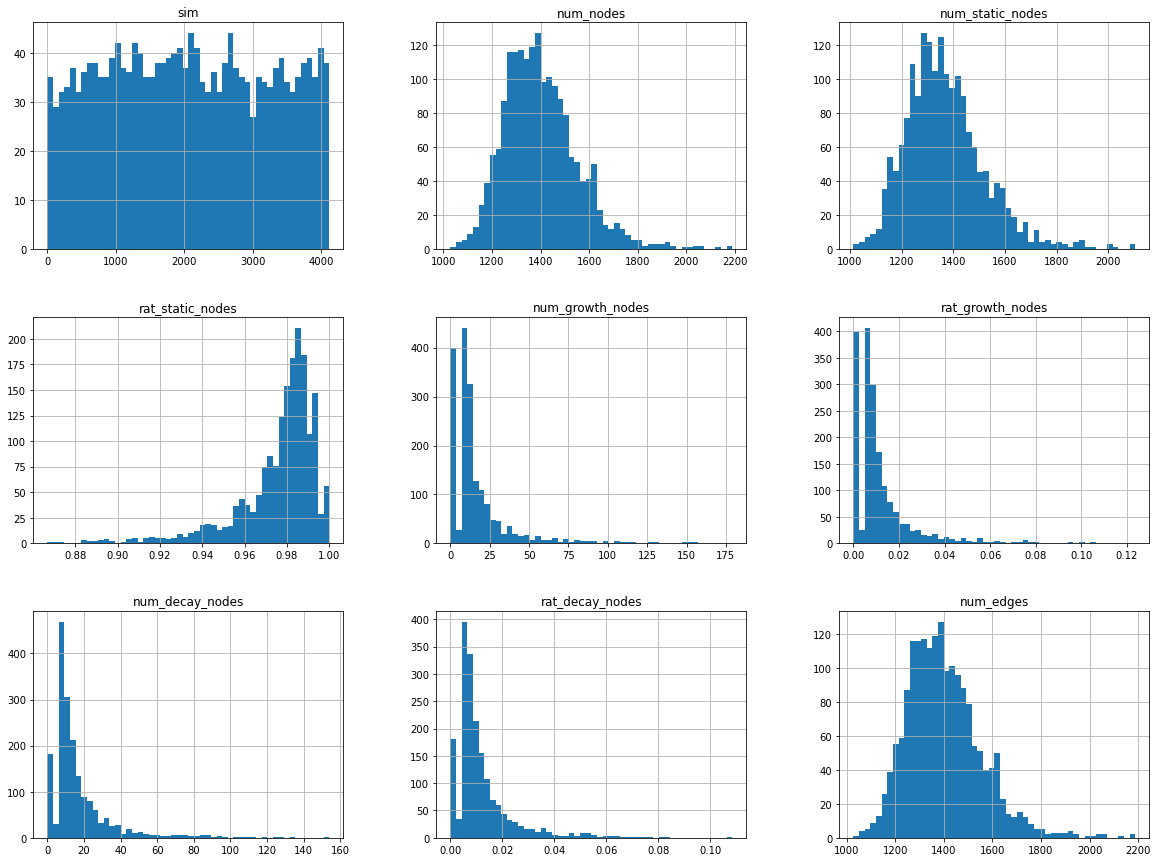

In [21]:
tree_dist_df.hist(bins=50,figsize=(20,15))

### Split the train/test sets

In [22]:
random_seed = 123
np.random.seed(random_seed)
split_folder = f'../data/{ds_name}/split_rs{random_seed}'
os.makedirs(split_folder, exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 1458, Test: 365
[3087 3270  689  817 1091  949  215 2913 3580 2237]


In [23]:
train_edge_df = edge_df[edge_df['sim'].isin(train_ids)]
test_edge_df = edge_df[edge_df['sim'].isin(test_ids)]

print(f'Train edges: {train_edge_df.shape[0]}')
print(f'Test edges: {test_edge_df.shape[0]}')

Train edges: 2042269
Test edges: 510102


### Normalize the edge weights

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

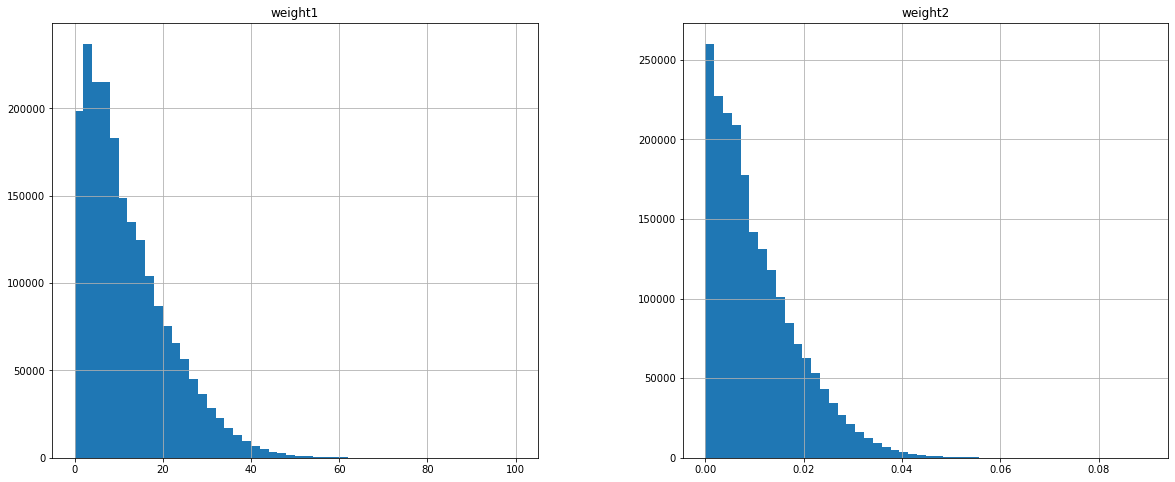

In [24]:
train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [25]:
train_edge_df['weight1'].describe()

count    2.042269e+06
mean     1.163669e+01
std      9.485616e+00
min      0.000000e+00
25%      4.000000e+00
50%      9.000000e+00
75%      1.700000e+01
max      1.000000e+02
Name: weight1, dtype: float64

In [26]:
train_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(train_edge_df['weight1'])

In [27]:
train_edge_df['weight2'].describe()

count    2.042269e+06
mean     1.047395e-02
std      8.582522e-03
min      0.000000e+00
25%      3.761793e-03
50%      8.227951e-03
75%      1.519413e-02
max      8.970291e-02
Name: weight2, dtype: float64

In [28]:
train_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(train_edge_df['weight2'])

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh'}>,
        <AxesSubplot:title={'center':'weight2_arsinh'}>]], dtype=object)

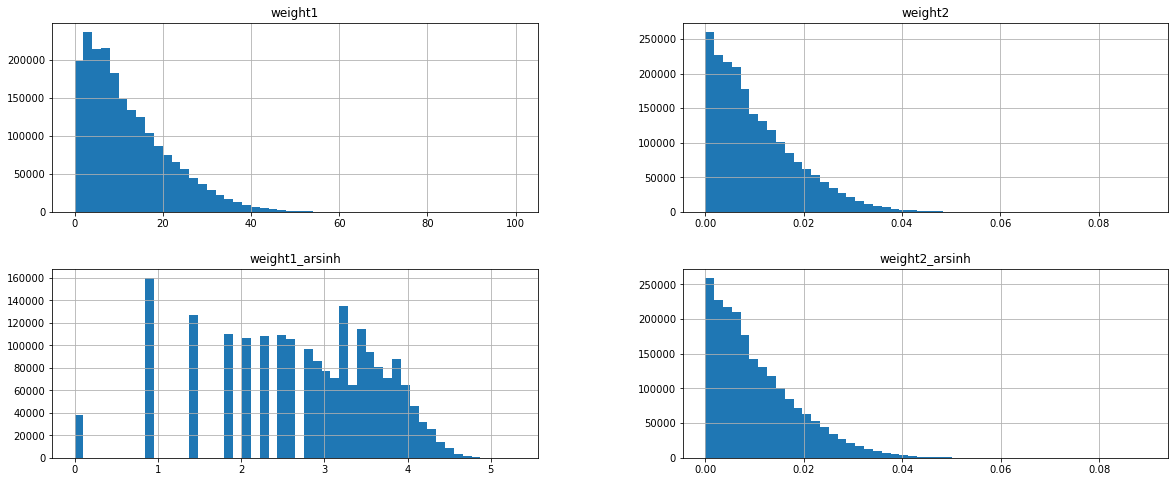

In [29]:
aly_edge_feat_cols += ['weight1_arsinh', 'weight2_arsinh']

train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [30]:
from sklearn import preprocessing

# Standardization edge features
std_scaler = preprocessing.StandardScaler().fit(train_edge_df[aly_edge_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in aly_edge_feat_cols]

norm_train_vals = std_scaler.transform(train_edge_df[aly_edge_feat_cols])
norm_train_edge_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_edge_df.index)
train_edge_df = pd.concat([train_edge_df, norm_train_edge_df], axis=1)

In [31]:
train_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
2765,680,681,4,0.003653,1005,2.094713,0.003653,-0.805081,-0.794796,-0.653676,-0.794843
2766,681,682,4,0.003380,1005,2.094713,0.003380,-0.805081,-0.826541,-0.653676,-0.826593
2767,682,683,1,0.000984,1005,0.881374,0.000984,-1.121350,-1.105703,-1.861912,-1.105800
2768,683,684,10,0.009551,1005,2.998223,0.009550,-0.172544,-0.107582,0.246033,-0.107535
2769,684,685,2,0.001656,1005,1.443635,0.001656,-1.015927,-1.027445,-1.302015,-1.027529
...,...,...,...,...,...,...,...,...,...,...,...
3948745,1180,136,3,0.002905,99,1.818446,0.002905,-0.910504,-0.881910,-0.928780,-0.881971
3948746,1180,317,7,0.006492,99,2.644121,0.006492,-0.488813,-0.463920,-0.106579,-0.463919
3948747,1179,1181,8,0.006875,99,2.776472,0.006875,-0.383390,-0.419306,0.025216,-0.419299
3948748,1181,98,15,0.014371,99,3.402307,0.014370,0.354570,0.454048,0.648417,0.454146


In [32]:
print(std_scaler.mean_, std_scaler.scale_)

[1.16366904e+01 1.04739450e-02 2.75115021e+00 1.04732444e-02] [9.48561319e+00 8.58251973e-03 1.00422420e+00 8.58113360e-03]


In [33]:
# Update the feat_dict.json
import json

js_f = osp.join('./feat_dict0427.json')

with open(js_f, 'r') as infile:
    feat_dict = json.load(infile)

feat_dict['raw_edge_feats'] = aly_edge_feat_cols
feat_dict['norm_edge_feats'] = [f'{org_feat_col}-norm' for org_feat_col in aly_edge_feat_cols]

node_feat_cols = feat_dict['norm_onehot_feats']
raw_edge_feat_cols = feat_dict['raw_edge_feats']
norm_edge_feat_cols = feat_dict['norm_edge_feats']

print(f'Inputs: {len(node_feat_cols)}, {node_feat_cols}')
label_feat_col = 'dynamic_cat'

with open(js_f, 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)

Inputs: 20, ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']


In [34]:
test_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(test_edge_df['weight1'])
test_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(test_edge_df['weight2'])
test_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh
0,711,712,10,0.008729,1003,2.998223,0.008729
1,712,713,16,0.013776,1003,3.466711,0.013775
2,713,714,2,0.001892,1003,1.443635,0.001892
3,714,715,2,0.001812,1003,1.443635,0.001812
4,715,716,1,0.000917,1003,0.881374,0.000917
...,...,...,...,...,...,...,...
3942288,1278,329,11,0.009403,987,3.093102,0.009403
3942289,1278,545,11,0.009193,987,3.093102,0.009192
3942290,1220,1279,59,0.056643,987,4.770756,0.056613
3942291,1279,383,5,0.004833,987,2.312438,0.004833


In [35]:
norm_test_vals = std_scaler.transform(test_edge_df[raw_edge_feat_cols])
norm_test_edge_df = pd.DataFrame(norm_test_vals, columns=norm_edge_feat_cols, index=test_edge_df.index)
test_edge_df = pd.concat([test_edge_df, norm_test_edge_df], axis=1)

In [36]:
test_edge_df.head()

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,711,712,10,0.008729,1003,2.998223,0.008729,-0.172544,-0.203283,0.246033,-0.203247
1,712,713,16,0.013776,1003,3.466711,0.013775,0.459992,0.384724,0.712551,0.384817
2,713,714,2,0.001892,1003,1.443635,0.001892,-1.015927,-0.999956,-1.302015,-1.000036
3,714,715,2,0.001812,1003,1.443635,0.001812,-1.015927,-1.009305,-1.302015,-1.009386
4,715,716,1,0.000917,1003,0.881374,0.000917,-1.121350,-1.113523,-1.861912,-1.113622


array([[<AxesSubplot:title={'center':'weight1-norm'}>,
        <AxesSubplot:title={'center':'weight2-norm'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh-norm'}>,
        <AxesSubplot:title={'center':'weight2_arsinh-norm'}>]],
      dtype=object)

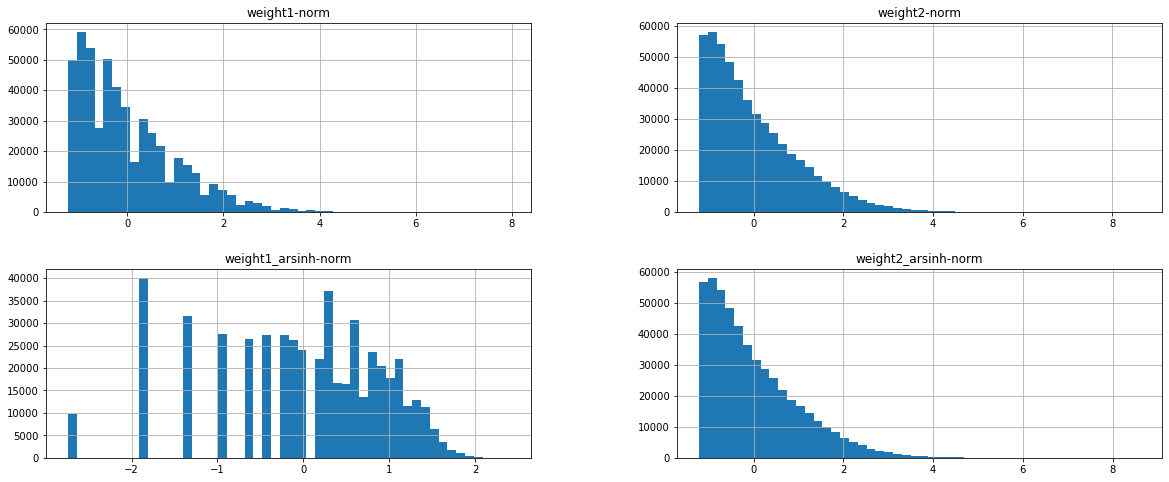

In [37]:
test_edge_df[norm_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [38]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Valid: {len(valid_ids)}")
print(valid_ids[:10])

Train: 1093, Valid: 365
[3898 3176  316 2558 1740 3871 1067 2087 2653 2960]


In [39]:
train_full_df = train_edge_df[train_edge_df['sim'].isin(train_ids)]
valid_full_df = train_edge_df[train_edge_df['sim'].isin(valid_ids)]

print(f'Train edge: {train_full_df.shape[0]}')
print(f'Valid edge: {valid_full_df.shape[0]}')
train_full_df.head()

Train edge: 1526477
Valid edge: 515792


,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
5270,686,687,1,0.000998,1007,0.881374,0.000998,-1.121350,-1.104057,-1.861912,-1.104154
5271,687,688,23,0.020737,1007,3.829114,0.020736,1.197952,1.195826,1.073429,1.195927
5272,688,2,1,0.000846,1007,0.881374,0.000846,-1.121350,-1.121859,-1.861912,-1.121959
5273,688,689,20,0.018961,1007,3.689504,0.018959,0.881684,0.988823,0.934407,0.988932
5274,689,690,12,0.010870,1007,3.179785,0.010870,0.038301,0.046178,0.426832,0.046243


In [40]:
# Save the train/test to the disk

train_full_df.to_csv(f'{split_folder}/train_edge.csv', index=False)
valid_full_df.to_csv(f'{split_folder}/valid_edge.csv', index=False)
test_edge_df.to_csv(f'{split_folder}/test_edge.csv', index=False)

### Build a tree with DGL

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

In [44]:
# Load a tree from the train data
train_node_df = pd.read_csv(f'{split_folder}/train.csv')
vis_tree_id = train_ids[0]
print(vis_tree_id)

3709


In [35]:
onetree_node_df = train_node_df[train_node_df['sim'] == vis_tree_id] 
onetree_edge_df = train_edge_df[edge_df['sim'] == vis_tree_id]

/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [36]:
onetree_node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,dynamic_model-norm
2775389,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2775390,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2775391,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2775392,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2775393,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109


In [37]:
onetree_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
3463830,680,681,16,0.015455,3765,3.466711,0.015454,0.463636,0.584134,0.714927,0.584238
3463831,681,682,11,0.009374,3765,3.093102,0.009374,-0.064298,-0.125496,0.343090,-0.125450
3463832,682,683,9,0.007374,3765,2.893444,0.007374,-0.275471,-0.358850,0.144379,-0.358835
3463833,683,684,26,0.024879,3765,3.951613,0.024876,1.519502,1.683876,1.197529,1.683929
3463834,684,12,1,0.000835,3765,0.881374,0.000835,-1.120164,-1.121962,-1.858146,-1.122062
...,...,...,...,...,...,...,...,...,...,...,...
3465139,1314,151,15,0.012676,3765,3.402307,0.012676,0.358049,0.259875,0.650828,0.259959
3465140,1314,224,16,0.013741,3765,3.466711,0.013740,0.463636,0.384091,0.714927,0.384183
3465141,1313,1315,12,0.011058,3765,3.179785,0.011058,0.041289,0.071095,0.429362,0.071161
3465142,1315,395,12,0.010630,3765,3.179785,0.010630,0.041289,0.021145,0.429362,0.021206


In [38]:
import dgl
import networkx as nx
import torch
import pygraphviz as pgv

Using backend: pytorch


In [39]:
src_ids = torch.tensor(onetree_edge_df['from'].values)
dst_ids = torch.tensor(onetree_edge_df['to'].values)

# Note: the start idx of the node is 0 not 1. But simulation node starts with 1
# We need substract 1 to the node idx for edges and nodes files.
src_ids -= 1
dst_ids -= 1

In [40]:
g = dgl.graph((src_ids, dst_ids))
nx_g = dgl.to_networkx(g)

print(f'Nodes: {g.number_of_nodes()}')
print(f'Edges: {g.number_of_edges()}')

Nodes: 1315
Edges: 1314


In [41]:
g.nodes()

tensor([   0,    1,    2,  ..., 1312, 1313, 1314])

### Assign features to nodes

In [42]:
sorted_onetree_node_df = onetree_node_df.sort_values(by='node')
print(sorted_onetree_node_df['node'].values)
n_nodes = sorted_onetree_node_df.shape[0]
sorted_onetree_node_df.tail()

[1.000e+00 2.000e+00 3.000e+00 ... 1.313e+03 1.314e+03 1.315e+03]


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,dynamic_model-norm
2776512,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2776552,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2776566,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2776537,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2776564,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109


<AxesSubplot:>

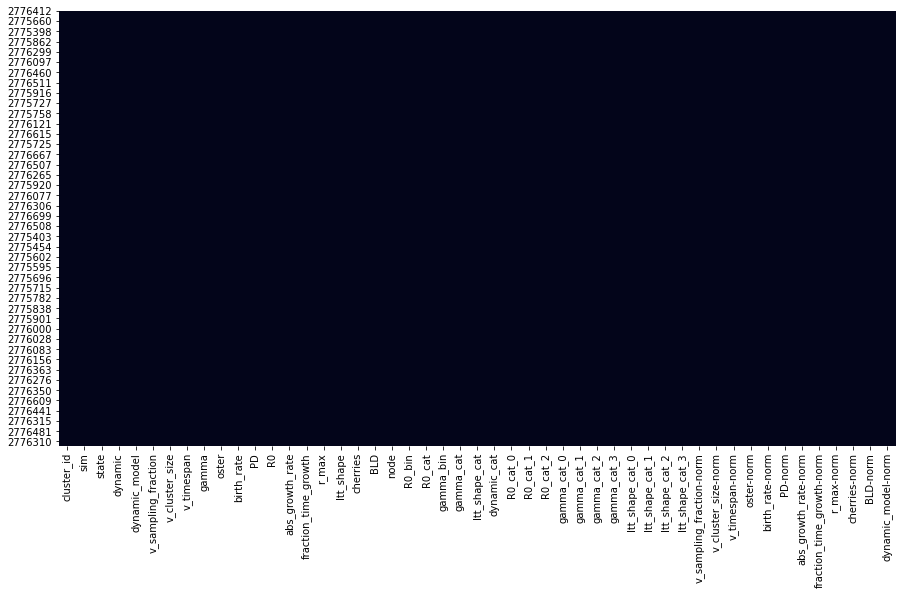

In [43]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(sorted_onetree_node_df.isnull(), cbar=False)

<AxesSubplot:>

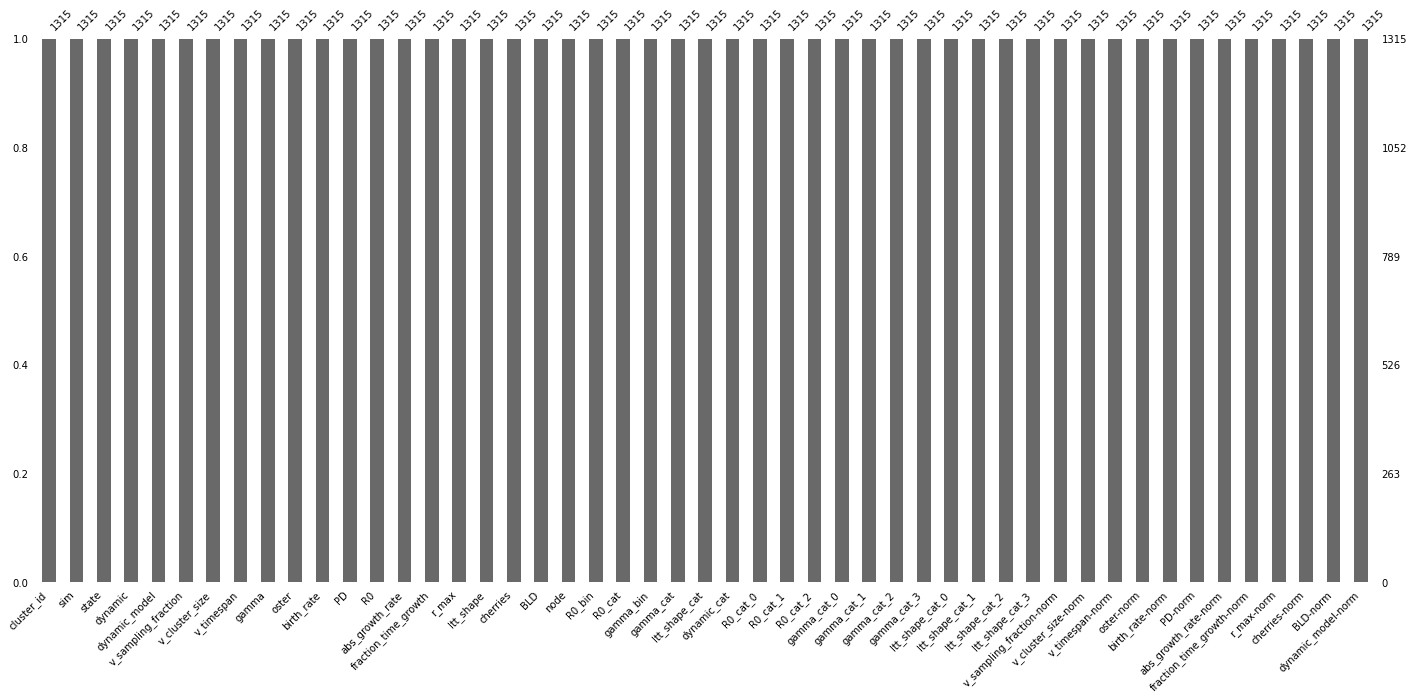

In [44]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(sorted_onetree_node_df,labels=True,fontsize=10) 

In [45]:
g.ndata['feat'] = torch.tensor(sorted_onetree_node_df[node_feat_cols].values)
g.ndata['label'] = torch.tensor(sorted_onetree_node_df[label_feat_col].values)

for i in range(n_nodes):
    if not torch.all(torch.isnan(g.ndata['feat'][i])):
        print(f"NodeID: {i+1}, {g.ndata['feat'][i]}, {g.ndata['label'][i]}")
        break

NodeID: 1, tensor([-0.3804,  0.2226,  0.3665,  0.3665, -0.0051,  0.1298, -0.0055, -1.4311,
         0.0066,  0.2603, -0.0146, -0.1090,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000],
       dtype=torch.float64), 2


### Assign features to edges

In [46]:
g.edges()

(tensor([ 679,  680,  681,  ..., 1312, 1314, 1314]),
 tensor([ 680,  681,  682,  ..., 1314,  394,  653]))

In [47]:
# The edge features are assigned to the edata according to the edge order, not considerring the src and dst
g.edata['feat'] = torch.tensor(onetree_edge_df[norm_edge_feat_cols].values)
g.edata['feat'][0]

tensor([0.4636, 0.5841, 0.7149, 0.5842], dtype=torch.float64)

defaultdict(<function <lambda> at 0x7fb6e8cb5048>, {2: 1294, 0: 12, 1: 9})


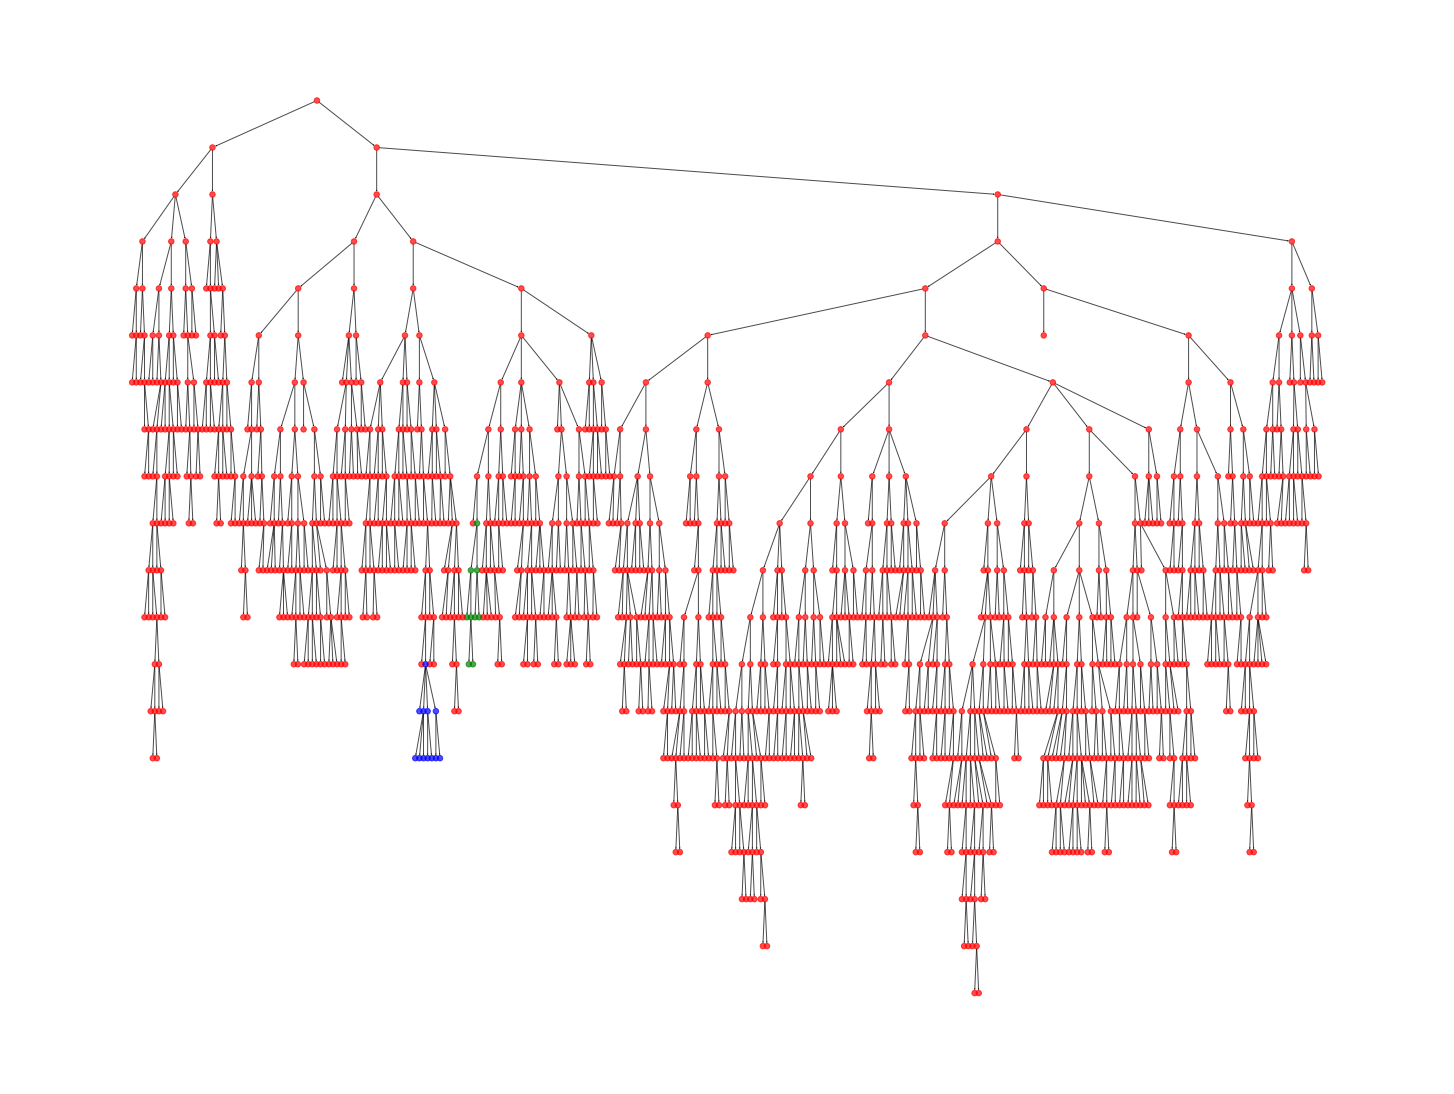

In [49]:
plt.figure(figsize=(20, 15))
color_map = []
node_labels = g.ndata['label'].numpy()
label_counter = defaultdict(lambda: 0)

for node_id in nx_g:
    node_label = node_labels[node_id]
    if np.isnan(node_label):
        label_counter['bg'] += 1
        color_map.append('gray')
    else:
        if node_label == 0:  # decay
            color_map.append('blue')
        elif node_label == 1:   # growth
            color_map.append('green')
        elif node_label == 2:   # static
            color_map.append('red')
        label_counter[node_label] += 1
            
print(label_counter)
pos = nx.nx_agraph.graphviz_layout(nx_g, prog='dot')
nx.draw(nx_g, pos, with_labels=False, node_size=30, node_color=color_map, alpha=.7, arrowsize=1)